In [156]:
import regex as re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open("prompt.txt", "r") as f:
    prompt = f.read()

In [3]:
df = pd.read_pickle("results")

In [4]:
print(prompt)

You are an expert in infering the sentiment of large documents based only on their small chunks.

In <sentence> you will be given one sentence extracted from a movie review.
Your task is to decide whether the whole review is positive or negative.

Keep in mind that:
1) You can use your general knowledge of cinema
2) The fact that <sentence> is positive, does not necessarily mean that the whole review is positive
3) Revievers can use humour, sarcasm, metaphors - you must excel at recognizing different means of human communication and do not let these cloud your judgement.

To complete the task, follow these steps:

1) Read the sentence carefully.
2) Explain your thought process.
3) Use your thought process to give a verdict - write "POSITIVE" or "NEGATIVE" depending on your judgement.

<sentence>
focuses on joan\'s raging hormones and sledgehammers the audience with spanish inquisitions about her " madness " so much that i became mad that i wasted 123 minutes and $9 . 50 on this 21st ce

In [5]:
print(df["llm_name"].unique())

['BAAI/AquilaChat-7B' 'baichuan-inc/Baichuan-7B' 'tiiuae/falcon-7b'
 'stabilityai/stablelm-tuned-alpha-7b' 'internlm/internlm-chat-7b'
 'mistralai/Mistral-7B-v0.1' '01-ai/Yi-6B' 'mosaicml/mpt-7b']


In [28]:
def retrieve_thought_process(llm_completion: str) -> str | None:
    pattern = re.compile("<thought process>(.*)<\/thought process>", flags=re.IGNORECASE|re.DOTALL)
    if match := re.search(pattern, llm_completion):
        return match.group(1)


def retrieve_verdict(llm_completion: str) -> str | None:
    pattern = re.compile("<verdict>\s?(POSITIVE|NEGATIVE)\s?<\/verdict>", flags=re.IGNORECASE)
    if match := re.search(pattern, llm_completion):
        verdict = match.group(1)
        if verdict == "POSITIVE":
            return 1
        elif verdict == "NEGATIVE":
            return 0

In [29]:
df["thought_process"] = df["llm_completion"].apply(retrieve_thought_process)
df["verdict"] = df["llm_completion"].apply(retrieve_verdict)

In [30]:
print("Missing thought process per model: ")
display(df.groupby("llm_name")["thought_process"].apply(lambda x: x.isna().mean()).sort_values(ascending=False).round(3))

Missing thought process per model: 


llm_name
BAAI/AquilaChat-7B                     1.000
01-ai/Yi-6B                            0.084
stabilityai/stablelm-tuned-alpha-7b    0.034
tiiuae/falcon-7b                       0.001
internlm/internlm-chat-7b              0.000
baichuan-inc/Baichuan-7B               0.000
mosaicml/mpt-7b                        0.000
mistralai/Mistral-7B-v0.1              0.000
Name: thought_process, dtype: float64

In [31]:
print("Missing verdict per model: ")
missing_verdicts_per_table = df.groupby("llm_name")["verdict"].apply(lambda x: x.isna().mean()).sort_values(ascending=False).round(3)
display(missing_verdicts_per_table)

Missing verdict per model: 


llm_name
BAAI/AquilaChat-7B                     0.993
01-ai/Yi-6B                            0.084
stabilityai/stablelm-tuned-alpha-7b    0.034
mosaicml/mpt-7b                        0.015
mistralai/Mistral-7B-v0.1              0.002
baichuan-inc/Baichuan-7B               0.001
tiiuae/falcon-7b                       0.001
internlm/internlm-chat-7b              0.000
Name: verdict, dtype: float64

Text(0.5, 0.98, 'Rate of missing verdicts per model')

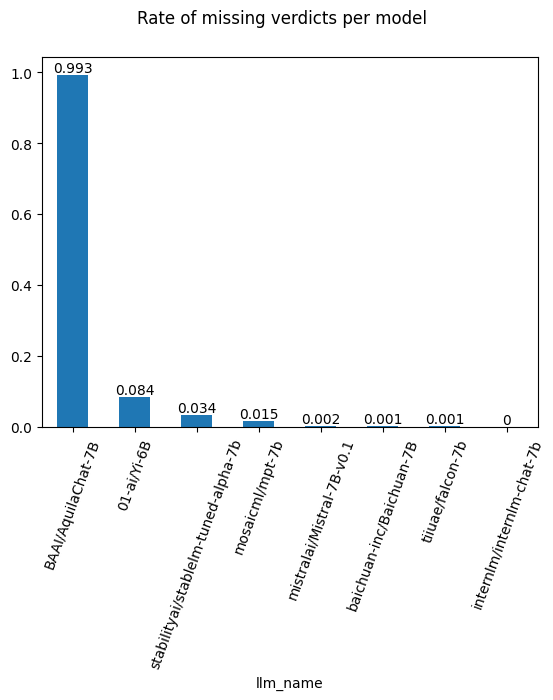

In [32]:
fig, ax = plt.subplots()
ax = missing_verdicts_per_table.plot.bar(rot=70, )
_ = ax.bar_label(ax.containers[0])
fig.suptitle("Rate of missing verdicts per model")

In [33]:
for model in df["llm_name"].unique():
    llm_missing_sample = df[df['verdict'].isna() & (df["llm_name"]==model)]["llm_completion"].values
    if len(llm_missing_sample) > 0:
        print(f"Example of missing verdict completion for {model}")
        display(llm_missing_sample[0])
        print("\n", "--"*30, "\n")

Example of missing verdict completion for BAAI/AquilaChat-7B


'<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<\n\n<</verdict>'


 ------------------------------------------------------------ 

Example of missing verdict completion for baichuan-inc/Baichuan-7B


'<thought process>\nNeutral sentence, but the mention of "entertaining" could be interpreted as a positive or negative sentiment depending on the context.\n</thought process>\n<verdict>\nNEUTRAL\n</verdict>'


 ------------------------------------------------------------ 

Example of missing verdict completion for tiiuae/falcon-7b


'<thought process>\nPositive words/phrases: "copious hints", "many signs", "funny surface", "bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far more meaningful", "far bigger", "far</verdict>'


 ------------------------------------------------------------ 

Example of missing verdict completion for stabilityai/stablelm-tuned-alpha-7b


'<thought process>\nPositive words/phrases: "enjoyable", "funny", "fun", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile", "worthwhile",</verdict>'


 ------------------------------------------------------------ 

Example of missing verdict completion for mistralai/Mistral-7B-v0.1


'<thought process>\nNeutral phrase: "mildly amusing" could be interpreted as a positive or negative sentiment depending on the context.\n</thought process>\n<verdict>\nNEUTRAL\n</verdict>'


 ------------------------------------------------------------ 

Example of missing verdict completion for 01-ai/Yi-6B


'<thought process>\nPositive words/phrases: "style and flash", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much fun", "so much</verdict>'


 ------------------------------------------------------------ 

Example of missing verdict completion for mosaicml/mpt-7b


'<thought process>\nNeutral sentence, but the mention of "american audiences" could be interpreted as a positive or negative sentiment depending on the context.\n</thought process>\n<verdict>\nNEUTRAL\n</verdict>'


 ------------------------------------------------------------ 



In [66]:
df["is_correct"] = (df["labels"] == df["verdict"]).astype(int)
df_sans_missing = df[~df['verdict'].isna()].copy()

In [67]:
accuracy = df.groupby("llm_name")["is_correct"].mean().sort_values(ascending=False)

In [68]:
accuracy_sans_missing = df_sans_missing.groupby("llm_name")["is_correct"].mean().sort_values(ascending=False).rename("is_correct_sans_missing")

In [70]:
accuracy_comparison = accuracy.to_frame().join(accuracy_sans_missing)

In [173]:
display(accuracy_comparison.sort_values(by='is_correct', ascending=False))

,is_correct,is_correct_sans_missing
llm_name,,
mistralai/Mistral-7B-v0.1,0.918386,0.920113
internlm/internlm-chat-7b,0.916510,0.916510
tiiuae/falcon-7b,0.893996,0.894836
baichuan-inc/Baichuan-7B,0.837711,0.838498
01-ai/Yi-6B,0.823640,0.899590
mosaicml/mpt-7b,0.714822,0.725714
stabilityai/stablelm-tuned-alpha-7b,0.484991,0.501942
BAAI/AquilaChat-7B,0.003752,0.571429


Text(0.5, 1.0, 'Accuracy per model')

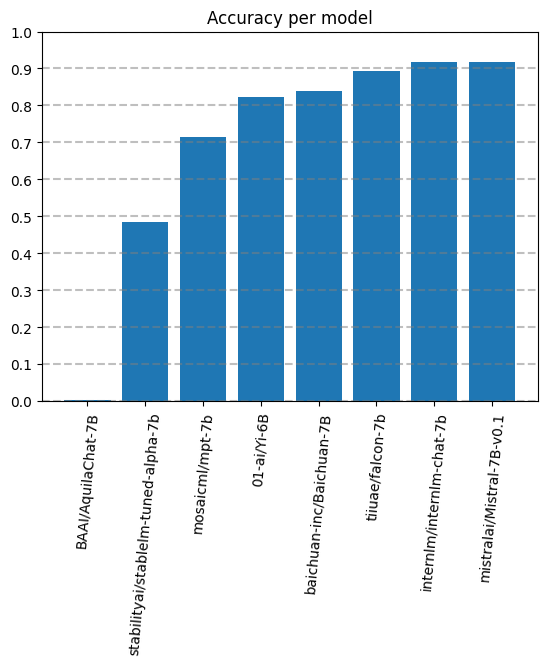

In [168]:
plt.bar(x=accuracy_comparison["is_correct"].sort_values().index,
        height=accuracy_comparison["is_correct"].sort_values())
_ = plt.xticks(rotation=85)
plt.yticks(np.arange(0, 1.1, 0.1))
for y in np.arange(0, 1.1, 0.1):
        plt.axhline(y, linestyle="--", c='grey', alpha=0.5)
plt.title("Accuracy per model")

Text(0.5, 1.0, 'Loss of accuracy due to missing verdicts per model')

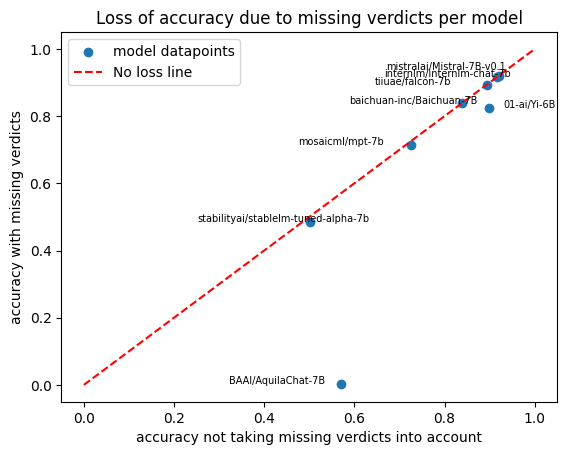

In [142]:
x = accuracy_comparison["is_correct_sans_missing"].values
y = accuracy_comparison["is_correct"].values
annots = accuracy_comparison.index
plt.scatter(x=x, y=y)
for i in range(len(accuracy_comparison)):
    plt.annotate(annots[i], (x[i]-0.25 if "Yi" not in annots[i] else x[i]+0.03, y[i] if "Mistral" not in annots[i] else y[i] + 0.02), fontsize=7)
plt.plot([0, 1], [0, 1], "r--")
plt.legend(["model datapoints", "No loss line"])
plt.xlabel("accuracy not taking missing verdicts into account")
plt.ylabel("accuracy with missing verdicts")
plt.title("Loss of accuracy due to missing verdicts per model")